#Import Lib

In [2]:
# Enable inline plotting in notebook
%matplotlib inline

# Imports
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Configuration parameters
CSV_PATH = 'controls_optimized.csv'   # Path to your cleaned/optimized CSV
IMAGE_DIR = 'images'                   # Folder containing images
MODEL_SAVE_PATH = 'selfdriving_model.h5'

BATCH_SIZE = 32
IMG_HEIGHT = 80       # Height for resizing images
IMG_WIDTH = 160       # Width for resizing images
CHANNELS = 3          # RGB or YUV channels (adjust if converted)
EPOCHS = 30


In [3]:
# If you want to run your cleaning steps again, place your cleaning code here.
# Otherwise, skip this and use the cleaned file `controls_optimized.csv` directly.

# Example: just load CSV and preview
df = pd.read_csv(CSV_PATH)
print(f"Dataset size before cleaning: {len(df)}")
df.head()


Dataset size before cleaning: 3146


,center_frame,left_frame,right_frame,steer,throttle,brake
0,center_00801.jpg,left_00801.jpg,right_00801.jpg,0.0000,1.0,0.0
1,center_02696.jpg,left_02696.jpg,right_02696.jpg,0.0011,1.0,0.0
2,center_03688.jpg,left_03688.jpg,right_03688.jpg,0.4019,1.0,0.0
3,center_03064.jpg,left_03064.jpg,right_03064.jpg,-0.0023,1.0,0.0
4,center_06285.jpg,left_06285.jpg,right_06285.jpg,0.0000,1.0,0.0


In [27]:
class DrivingDataGenerator(Sequence):
    def __init__(self, df, image_dir, batch_size=32, augment=True, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_inds = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.df.iloc[batch_inds]

        images = np.zeros((self.batch_size, IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.float32)
        controls = np.zeros((self.batch_size, 3), dtype=np.float32)
        
        for i, (_, row) in enumerate(batch_data.iterrows()):
            img_path = os.path.join(self.image_dir, row['center_frame'])
            img = cv2.imread(img_path)
            if img is None:
                raise FileNotFoundError(f"Image not found: {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

            steer, throttle, brake = row['steer'], row['throttle'], row['brake']

            if self.augment:
                img, steer = self.augment_image(img, steer)

            img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)  # <-- Convert here
            img = img / 255.0  # Normalize to [0,1]

            images[i] = img
            controls[i] = [steer, throttle, brake]
        
        return images, controls
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def augment_image(self, img, steer):
        # Random brightness
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        ratio = 1.0 + 0.4*(random.random() - 0.5)
        hsv[:,:,2] = np.clip(hsv[:,:,2] * ratio, 0, 255)
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        # Random horizontal flip
        if random.random() < 0.5:
            img = cv2.flip(img, 1)
            steer = -steer

        # Random translation (shift)
        if random.random() < 0.5:
            tr_x = random.randint(-20, 20)
            steer += tr_x * 0.005
            trans_mat = np.float32([[1, 0, tr_x], [0, 1, 0]])
            img = cv2.warpAffine(img, trans_mat, (img.shape[1], img.shape[0]))

        return img, steer


In [28]:
# Load dataset CSV
df = pd.read_csv(CSV_PATH)

# Preview data
print(f"Total samples: {len(df)}")
df.head()

# Split into train and validation (e.g., 80-20 split)
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Create generators
train_gen = DrivingDataGenerator(train_df, IMAGE_DIR, batch_size=BATCH_SIZE, augment=True, shuffle=True)
val_gen = DrivingDataGenerator(val_df, IMAGE_DIR, batch_size=BATCH_SIZE, augment=False, shuffle=False)


Total samples: 3146
Training samples: 2516, Validation samples: 630


In [29]:
def build_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)):
    model = Sequential()
    # Normalize input from [0,255] to [-1,1]
    model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=input_shape))
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3))  # Output: steer, throttle, brake
    return model

model = build_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 80, 160, 3)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 38, 78, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 17, 37, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 17, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 5, 15, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 13, 64)         36928     
                                                                 
 flatten_2 (Flatten)         (None, 2496)             

In [30]:
model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


In [16]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
78/78 [==============================] - 19s 236ms/step - loss: 0.1725 - val_loss: 0.0840 - lr: 0.0010
Epoch 2/30
78/78 [==============================] - 19s 249ms/step - loss: 0.0942 - val_loss: 0.0785 - lr: 0.0010
Epoch 3/30
78/78 [==============================] - 19s 244ms/step - loss: 0.0836 - val_loss: 0.0702 - lr: 0.0010
Epoch 4/30
78/78 [==============================] - 19s 239ms/step - loss: 0.0764 - val_loss: 0.0702 - lr: 0.0010
Epoch 5/30
78/78 [==============================] - 18s 232ms/step - loss: 0.0730 - val_loss: 0.0685 - lr: 0.0010
Epoch 6/30
78/78 [==============================] - 18s 235ms/step - loss: 0.0719 - val_loss: 0.0675 - lr: 0.0010
Epoch 7/30
78/78 [==============================] - 19s 238ms/step - loss: 0.0701 - val_loss: 0.0677 - lr: 0.0010
Epoch 8/30
78/78 [==============================] - 19s 238ms/step - loss: 0.0691 - val_loss: 0.0673 - lr: 0.0010
Epoch 9/30
78/78 [==============================] - 18s 236ms/step - loss: 0.0692 - val_

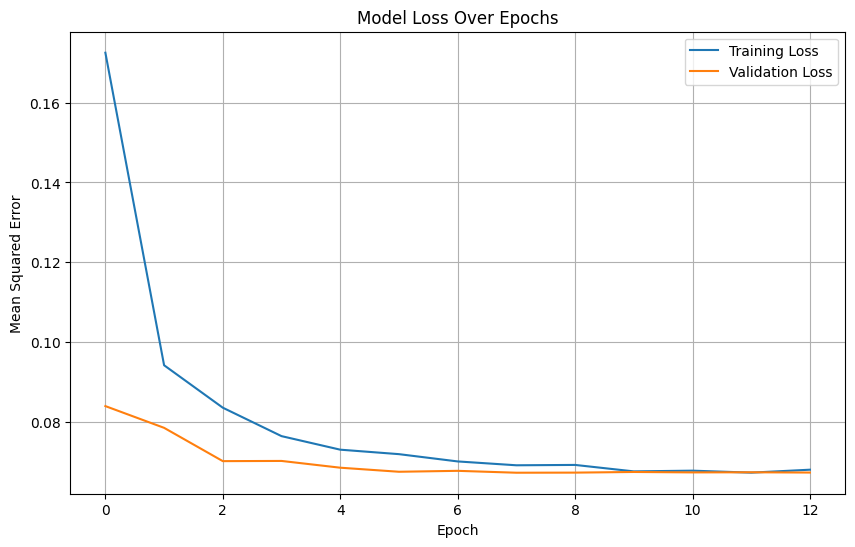

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()
plt.show()

In [18]:
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to selfdriving_model.h5


In [22]:
# Predict on one batch from the validation generator
X_val, y_val = val_gen[0]
y_pred = model.predict(X_val)

# If you want to predict on the whole validation set, unroll all batches:
# X_val_all = np.concatenate([val_gen[i][0] for i in range(len(val_gen))])
# y_val_all = np.concatenate([val_gen[i][1] for i in range(len(val_gen))])
# y_pred_all = model.predict(X_val_all)

1/1 [==============================] - 0s 27ms/step


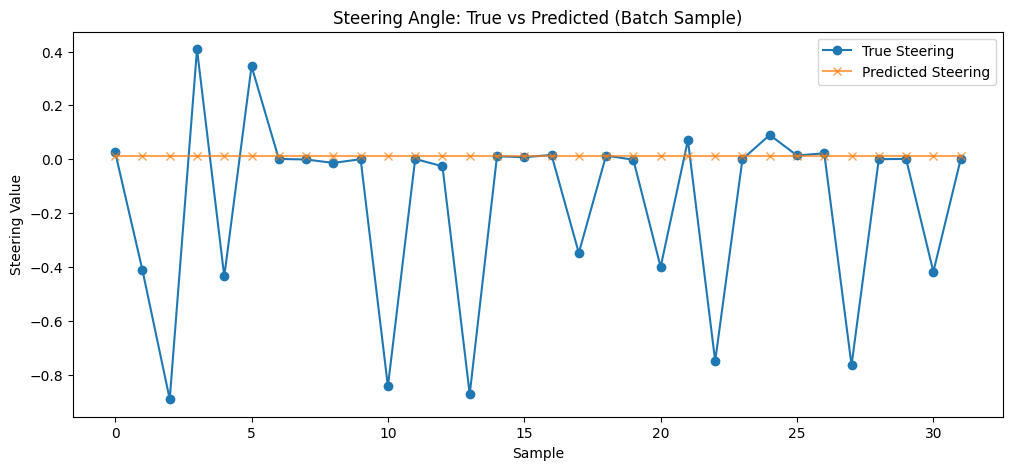

In [23]:
plt.figure(figsize=(12,5))
plt.plot(y_val[:,0], label='True Steering', marker='o')
plt.plot(y_pred[:,0], label='Predicted Steering', alpha=0.7, marker='x')
plt.title("Steering Angle: True vs Predicted (Batch Sample)")
plt.xlabel("Sample")
plt.ylabel("Steering Value")
plt.legend()
plt.show()


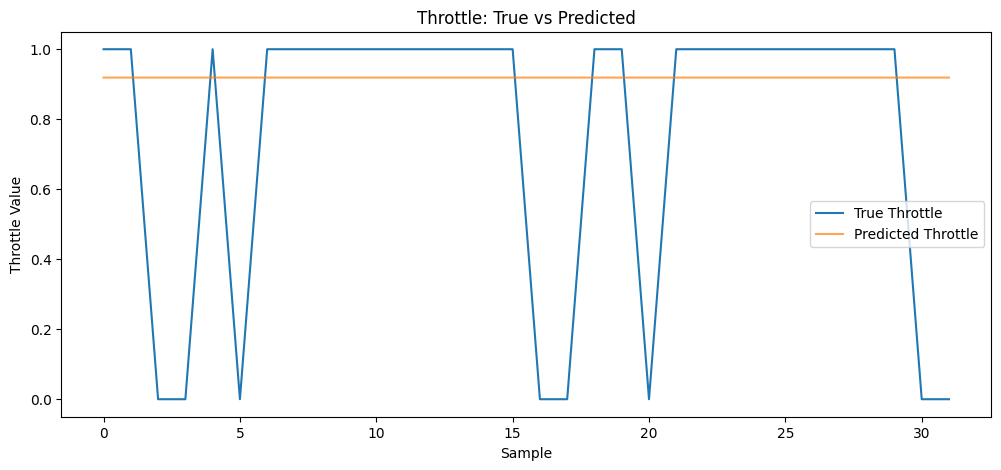

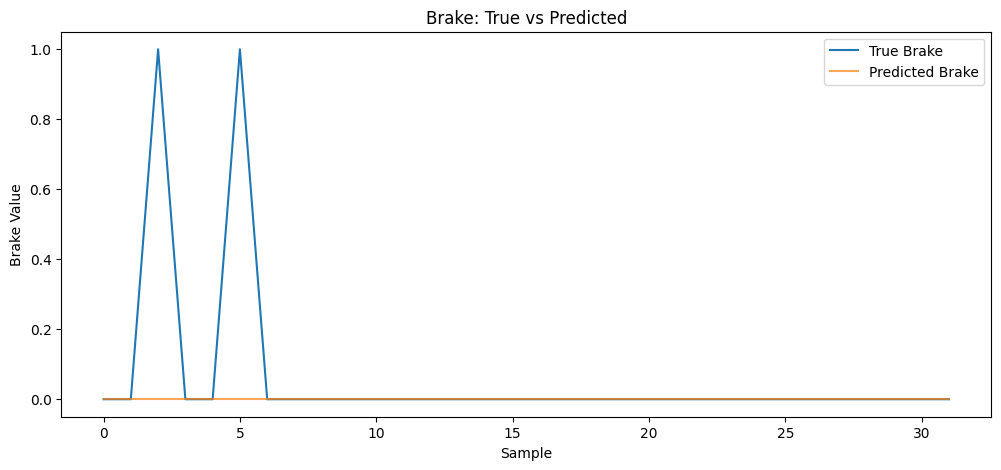

In [24]:
plt.figure(figsize=(12,5))
plt.plot(y_val[:,1], label='True Throttle')
plt.plot(y_pred[:,1], label='Predicted Throttle', alpha=0.7)
plt.title("Throttle: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Throttle Value")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_val[:,2], label='True Brake')
plt.plot(y_pred[:,2], label='Predicted Brake', alpha=0.7)
plt.title("Brake: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Brake Value")
plt.legend()
plt.show()


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

for i, name in enumerate(['Steering', 'Throttle', 'Brake']):
    mae = mean_absolute_error(y_val[:,i], y_pred[:,i])
    mse = mean_squared_error(y_val[:,i], y_pred[:,i])
    print(f"{name} — MAE: {mae:.4f}, MSE: {mse:.4f}")


Steering — MAE: 0.2285, MSE: 0.1452
Throttle — MAE: 0.2905, MSE: 0.2160
Brake — MAE: 0.0629, MSE: 0.0624


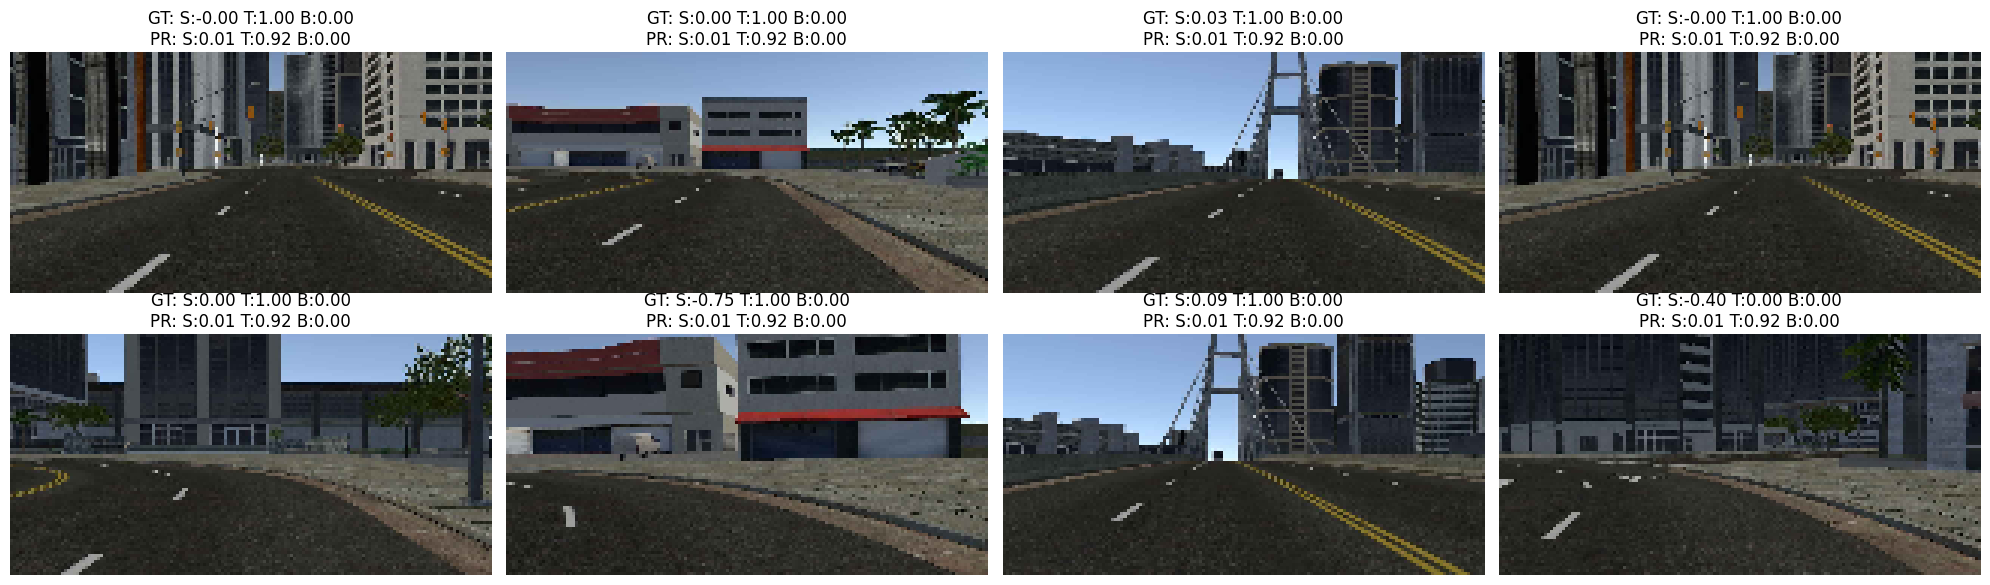

In [26]:
import random

n_vis = 8  # number to display
plt.figure(figsize=(20,6))
for i in range(n_vis):
    idx = random.randint(0, X_val.shape[0]-1)
    img = X_val[idx]
    steer_gt, throttle_gt, brake_gt = y_val[idx]
    steer_pred, throttle_pred, brake_pred = y_pred[idx]
    plt.subplot(2, n_vis//2, i+1)
    plt.imshow(img)
    plt.title(f"GT: S:{steer_gt:.2f} T:{throttle_gt:.2f} B:{brake_gt:.2f}\n"
              f"PR: S:{steer_pred:.2f} T:{throttle_pred:.2f} B:{brake_pred:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


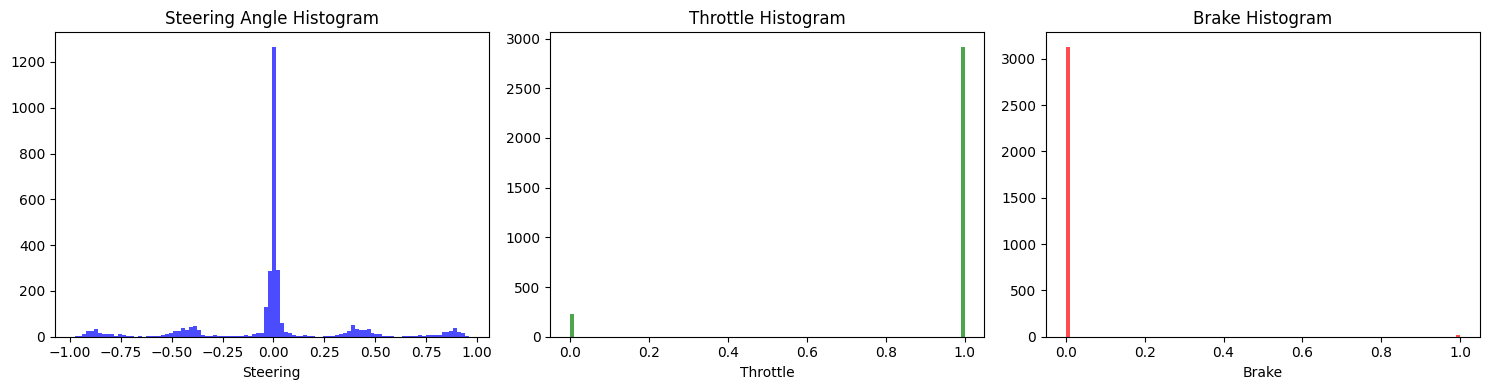

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('controls_optimized.csv')

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.hist(df['steer'], bins=100, color='blue', alpha=0.7)
plt.title('Steering Angle Histogram')
plt.xlabel('Steering')

plt.subplot(1,3,2)
plt.hist(df['throttle'], bins=100, color='green', alpha=0.7)
plt.title('Throttle Histogram')
plt.xlabel('Throttle')

plt.subplot(1,3,3)
plt.hist(df['brake'], bins=100, color='red', alpha=0.7)
plt.title('Brake Histogram')
plt.xlabel('Brake')

plt.tight_layout()
plt.show()


In [33]:
# Remove rows with out-of-range controls (e.g., |steering| > 1, throttle not in [0,1])
df_clean = df[
    (df['steer'].abs() <= 1.0) &
    (df['throttle'] >= 0.0) & (df['throttle'] <= 1.0) &
    (df['brake'] >= 0.0) & (df['brake'] <= 1.0)
]


In [35]:
df_clean['steer'] = df_clean['steer'].clip(-1.0, 1.0)
df_clean['throttle'] = df_clean['throttle'].clip(0.0, 1.0)
df_clean['brake'] = df_clean['brake'].clip(0.0, 1.0)


In [36]:
import numpy as np

window = 5  # You can increase (e.g. 9) for more smoothing
df_clean['steer_smoothed'] = df_clean['steer'].rolling(window=window, min_periods=1, center=True).mean()
df_clean['throttle_smoothed'] = df_clean['throttle'].rolling(window=window, min_periods=1, center=True).mean()
df_clean['brake_smoothed'] = df_clean['brake'].rolling(window=window, min_periods=1, center=True).mean()


In [37]:
df_clean.to_csv('controls_smoothed.csv', index=False)


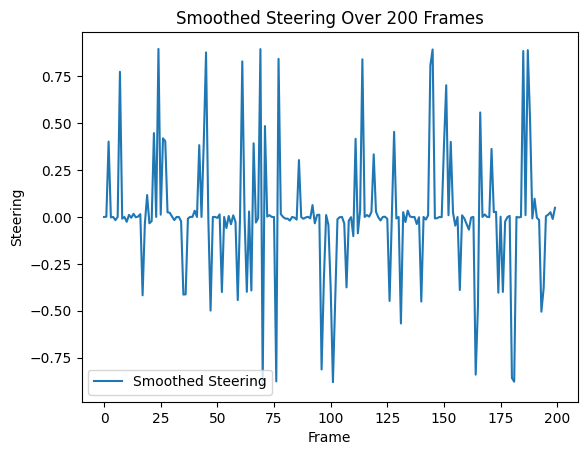

In [38]:
plt.plot(df_clean['steer'].values[:200], label='Smoothed Steering')
plt.title('Smoothed Steering Over 200 Frames')
plt.xlabel('Frame')
plt.ylabel('Steering')
plt.legend()
plt.show()
